# N.B.
- [ ] Create a class to save data into a file
- [ ] Check pauses into the codes and remove redundant ones (or add them if necessary).
- [ ] With sGen.pul_trig_mode(**'AUTO'**) there aren't errors, instead with sGen.pul_trig_mode(**'SING'**) (theorically more correct) the code stops working.  
    *-1074118634: The trigger has not occurred for the requested buffer, so data cannot be fetched relative to the trigger.*
- [ ] controllare se ad alte frequenze se le oscillazioni si vedono anche sull'oscilloscopio
- [ ] CHIEDERE RIGUARDO AI BATTIMENTI (ES SWEEP 39)



In [2]:
# Uscita trigger dal signal generator: Pulse Sync

%matplotlib widget
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import h5py
import time
import numpy as np

import sys
sys.path.insert(1, '..\\Instruments\\network\\Signal_Generator')
sys.path.insert(2, '..\\Instruments\\Acquisition_Card')

import RS_SMA100B
from Card_Class import *


ip              = '192.168.40.15'            # Set IP address of the device
Card_Name       = 'PXI1Slot3'
sGen            = RS_SMA100B.SMA100B(ip)
pxie            = PXIe5170R(Card_Name)

SMA100B: Connection successful!
5170R: Available communication!


# Setup parameters

In [28]:
# parameters for the Signal Generator
f_min           = 51e6                                  # tryout value
f_max           = 100e6                                  # tryout value
pulse_freq      = np.arange(f_min, f_max, 1e6)          # Set range of frequency of the signal to send to the resonator
amplitude       = -10                           # Set the amplitude of the signal in dBm

pulse_width     = 5                                 # 2 microsec
pulse_delay     = 5
pulse_period    = 1000  


sGen.reset()
sGen.clear()
sGen.RF_lvl_ampl(amplitude)
sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)   # da capire quale pulse width
sGen.pul_gen_mode('SING')
sGen.pul_trig_mode('SING')


# parameters for the Acquisition Card
pxie.voltage_range      = 2.0
pxie.coupling           = 'AC' # or DC????
pxie.num_pts            = 1000
pxie.num_records        = 1
pxie.ref_position       = 0
pxie.sample_rate        = 250e6 # Maximum Value: 250.0e6

pxie.open()


# Turn ON the modulation of the Signal Generator
sGen.pul_state(1)
sGen.RF_state(1)

# Acquisition of signals for each frequency in the range

In [29]:

slip = 0.0      # time of sleep of triggering

fetched_data = []

while True:
# for i in pulse_freq:
#     #pxie.sample_rate = 2 * i # f_sample > 2*f_max (Nyquist for every freq) 
    
#     sGen.RF_freq(i) # guarda come è definito, abbiamo messo la potenza e6   
    sGen.pul_state(1)
    sGen.RF_state(1)
    time.sleep(0.1)
    # wfm = pxie.acquisition(sGen.pul_exe_sing_trig,slip)
    wfm = pxie.acquisition(sGen.pul_exe_sing_trig)
    sGen.pul_state(0)
    sGen.RF_state(0)
#     fetched_data += [{'freq': i, 'data': wfm[0].samples.tolist()}]

# print('Number of sweeps:', len(fetched_data), '/', len(pulse_freq))


AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
AcquisitionStatus.IN_PROGRESS
Acquisitio

KeyboardInterrupt: 

# Plot of a sweep with the peaks of amplitudes marked

In [39]:
def data_amps(y: np.array, toggle_plot = True):
    x = np.arange(len(y))/pxie.sample_rate
    std = np.std(y)
    indices = find_peaks(y, prominence=2*(max(y) - std))
    idx = indices[0]
    offset = 5
    idx = idx[offset:-offset]
    
    if toggle_plot:
        # plt.clf()
        plt.grid()
        plt.plot(x, y)
        plt.scatter(x[idx],y[idx], color = 'orange')
        plt.draw()
    # return {'mean': np.mean(y[idx]), 'std' : np.std(y[idx])}
    return (x, idx)

In [ ]:
# n_sweep = 19

# f_chosen = fetched_data[n_sweep]
# print('freq:', f_chosen['freq'])
# y = np.array(f_chosen['data'])
# data_amps(y)
# std = np.std(y)
# indices = find_peaks(y, prominence=2*(max(y) - std))

# # print('mean', np.mean(y[indices[0]]))

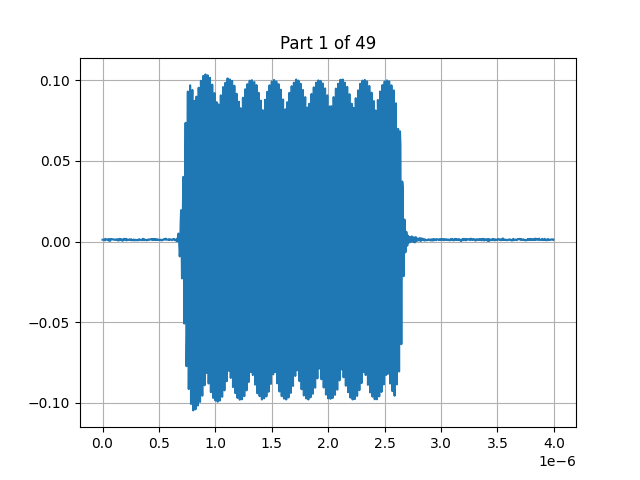

In [ ]:
sweep = 0
f_chosen = fetched_data[sweep]
y = np.array(f_chosen['data'])
x, idx = data_amps(y, toggle_plot = False)

def on_key(event):
    global sweep
    if event.key == 'right':
        sweep += 1
    elif event.key == 'left':
        sweep -= 1

    if (sweep+1) > len(fetched_data) or sweep == -1:
        sweep = 0

    f_chosen = fetched_data[sweep]
    y = np.array(f_chosen['data'])
    x, idx = data_amps(y, toggle_plot = False)

    # clear frame
    plt.clf()
    plt.title(f'Part {sweep+1} of {len(fetched_data)}')
    plt.grid()
    plt.plot(x, y)
    plt.scatter(x[idx],y[idx], color = 'orange')
    plt.draw() # redraw



fig,ax=plt.subplots()
plt.title(f'Part {sweep+1} of {len(fetched_data)}')
plt.plot(x, y)
fig.canvas.mpl_connect('key_press_event',on_key)
plt.grid()
plt.show()
plt.draw()

# Save data on HDF5 file

In [ ]:
# with h5py.File('nonloso_2.hdf5', 'a') as f:                      # creo file hdf5 di nome tra virgolette e lo apro in modalità a = appen
#     for j in range(0, len(fetched_data)):
#         gp_data = f.create_group(str(j))
#         freq, data = fetched_data[j].items()
#         gp_data.create_dataset(str(freq[0]), data = freq[1])
#         gp_data.create_dataset(str(data[0]), data = data[1])

# Read data from HDF5 file

In [ ]:
# with h5py.File('nonloso.hdf5', 'r') as f:
#     idx = 4
#     gp = f[str(idx)]
#     dic = {}
#     for i, k in gp.items():
#         dic[i] = k[()]
# freq = dic['freq']
# data = dic['data']
# plt.clf()
# data_plot(data)

# plt.show()


# First Data Analysis tryout

In [ ]:
# offset = 2.5e-6
# end = 5e-6

# with h5py.File('nonloso.hdf5', 'r'):
    

In [ ]:
# amps = []
# with h5py.File('nonloso_2.hdf5', 'r') as f:
#     for j in range(1,len(f)):
#         gp = f[str(j)]
#         dic = {}
#         for i, k in gp.items():
#             dic[i] = k[()]
#         freq = dic['freq']
#         data = dic['data']

            
#         amps = amps + [data_amps(data, False)['mean']]


# plt.clf()
# plt.plot(amps)
# plt.show()

In [77]:
fetched_data = []
with h5py.File('nonloso_2.hdf5', 'r') as f:
    
    for j in range(len(f)):
        dic = {}
        gp = f[str(j)]
        for i, k in gp.items():
            dic[i] = k[()]
        fetched_data += [dic]

15

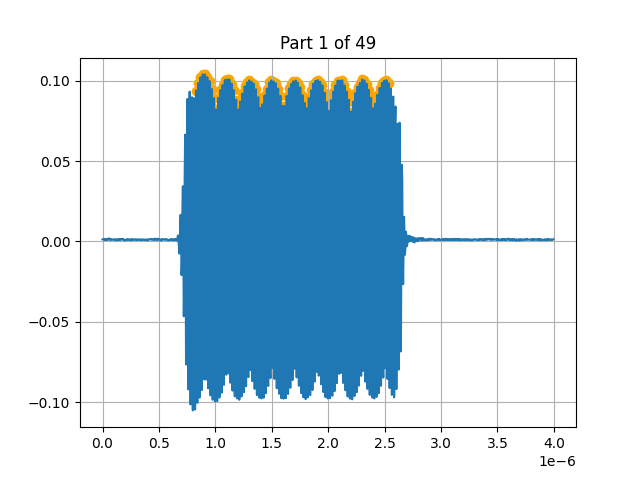

In [62]:
sweep = 0
f_chosen = fetched_data[sweep]
y = np.array(f_chosen['data'])
fig,ax=plt.subplots()
plt.title(f'Part {sweep+1} of {len(fetched_data)}')
x, idx = data_amps(y, toggle_plot = True)

def on_key(event):
    global sweep
    if event.key == 'right':
        sweep += 1
    elif event.key == 'left':
        sweep -= 1

    if (sweep+1) > len(fetched_data) or sweep == -1:
        sweep = 0

    f_chosen = fetched_data[sweep]
    y = np.array(f_chosen['data'])
    x, idx = data_amps(y, toggle_plot = False)

    # clear frame
    plt.clf()
    plt.title(f'Part {sweep+1} of {len(fetched_data)}')
    plt.grid()
    plt.plot(x, y)
    plt.scatter(x[idx],y[idx], color = 'orange')
    plt.draw() # redraw

fig.canvas.mpl_connect('key_press_event',on_key)

# Demodulation with FT

51000000.0
[ 0.00000000e+00  4.50564780e-02  1.01287134e-02  2.34225086e-01
  1.00455165e-01  2.90479278e-01  1.06612065e-01 -1.03115258e-01
 -1.74925677e-02  4.44540548e-02  3.74863647e-02 -1.34316314e-01
 -1.07447621e-03 -1.43550396e-01 -5.76787725e-02 -6.36467457e-02
 -1.10583671e-01 -1.34452647e-01 -1.34763062e-01 -1.10107629e-01
 -2.81743673e-02 -8.38614383e-02 -1.21748782e-01  3.58404485e-02
  6.46373985e-02 -2.08933646e-01 -5.39376715e-03 -8.79751278e-02
 -6.93624323e-02  7.36309871e-02  1.36889293e-01  1.18195094e-02
  4.61824792e-02 -6.62454100e-02 -3.61854433e-02  1.59055994e-01
 -1.67902524e-01 -8.73948933e-02 -3.74372250e-02  9.83693361e-02
 -5.13428481e-02 -1.05715377e-01 -8.34136013e-02 -7.95598685e-02
 -1.45460037e-01  3.28461626e-02  2.91359441e-02 -6.68791919e-02
 -1.09664682e-01  4.50935237e-03 -1.96773038e-02 -4.53180836e-03
 -5.55993385e-02 -4.51422231e-02 -5.04271296e-02 -2.24621066e-03
  3.05888650e-03 -1.66170931e-02  5.07120778e-02 -5.65876847e-02
  5.88673370e-

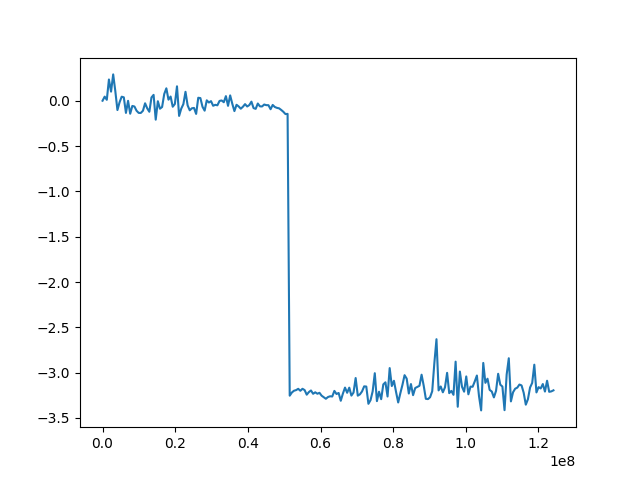

In [109]:
f_chosen = fetched_data[0]
print(f_chosen['freq'])
y = np.array(f_chosen['data'])
x, idx = data_amps(y, False)

l = idx[0]
r = idx[-1]

x_c = x[l:r]
y_c = y[l:r]

N = len(y_c)
T = 1/(250e6)
TFN = np.fft.fft(y_c) / N
frequencies = np.fft.fftfreq(N,T)

ph = np.unwrap(np.angle(TFN))

print(ph)
plt.clf()
plt.plot(frequencies[:N//2],ph[:N//2])
plt.show()

# plt.clf()
# plt.figure()
# plt.subplot(1,2,1)
# plt.plot(x,y)
# plt.subplot(1,2,2)
# # plt.plot(x_c, y_c*np.cos(f_chosen['freq']))
# plt.plot(np.convolve(x_c,y_c))
# plt.show()

In [73]:
a = '12345'
a[1:]

'2345'